# PyLorentz TIE Reconstruction Demo

Outline 
1. TIE reconstruction of an artificial spin ice 
2. SITIE reconstruction of Bloch-type bubbles in CGT

In this notebook we demonstrate solving the transport of intensity equation (TIE) and finding magnetic induction from an experimental LTEM images. For more information please check out our [wiki/documentation pages](https://pylorentztem.readthedocs.io/en/latest/). 

If you have never used a Jupyter Notebook before we recommend familiarizing yourself with the [notebook basics](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Notebook%20Basics.html). While Python knowledge is not strictly required for running PyLorentz code, a certain familiarity is helpful for understanding how to modify the examples to suit your needs. 

This notebook is ready to be run as-is. The first time, however, you will need to [download the example data from zenodo/DOI](https://zenodo.com). Cells can be executed by selecting and pressing ``shift + enter``, and you can proceed with running all of the cells in order. The python docstrings for these functions can be found on the wiki, but are also viewable in Jupyter. E.g. for the TIE() function, executing a cell containing: `?TIE` will pull up the documentation for that function. 
  
Authors: Arthur McCray, CD Phatak  
V2.0, LBL/ANL, July 2024

## Importing the necessary modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
# matplotlib widget is recommended for interactive ROI selection

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from PyLorentz.io import read_image, write_tif, write_json
from PyLorentz.dataset import ThroughFocalSeries, DefocusedDataset
from PyLorentz.tie import TIE, SITIE
from PyLorentz.visualize import show_im, show_stack, show_2D

## Loading the data into PyTIE
The example data used for all demo notebooks can be [downloaded here](https://zenodo.com). The demo notebook default filepaths expect the downloaded files to be unzipped and placed in PyLorentz/Examples/data. 

Pylorentz is built around two data classes: 
* DefocusedDataset: which contains individual or multiple LTEM images and their associated metadata, to be used for single-image reconstruction methods. 
* ThroughFocalSeries: which contains a TFS of images for use with reconstruction methods that require multiple images. 

In this example we use the TFS class, which consists of an (unflip) aligned stack of images, an aligned stack of flipped images, and an associated metadata.json file. 

Metadata can be read through a json file or entered manually using the TFS.load() method, or a TFS can be created directly from a numpy array using the TFS \_\_init__ directly. The required arguments are: 
- imstack/aligned_file: The aligned (unflip) image stack, or the filepath which will be loaded. 
- flipstack/aligned_flip_file: (optional) Used if performing a reconstruction with two TFS. 
- scale: image scale in nm/pixel 
- defocus_values: list of defocus values in the TFS, formatted as [underfocus2, underfocus1, 0, overfocus1, overfocus2]. The defocus values should match between the unflip and flip stacks if applicable.
- beam_energy: accelerating voltage of the microscope 

Scale, defocus values, and beam_energy are contained within the tfs_mdata.json file. 

In [3]:
aligned_file = "./data/cphatak_PyLorentz_example_v2/aligned_stack.tif"
aligned_flip_file = "./data/cphatak_PyLorentz_example_v2/aligned_flip_stack.tif"
tfs_mdata_file = "./data/cphatak_PyLorentz_example_v2/tfs_mdatap.json"
tfs = ThroughFocalSeries.load(
    aligned_file=aligned_file,
    aligned_flip_file=aligned_flip_file,
    metadata_file=tfs_mdata_file,
)

tfs.preprocess(fast=True)  # filtering hot/dead pixels and masking

Filtering hot/dead pixels


100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


### Loading data in legacy format with a .fls file
Old data referenced with a .fls file can also be loaded, including using a full_align file containing the concatenated unflip and flip stacks.

We additionally specify the beam_energy here, but this could also be done when performing the TIE reconstruction. 

In [ ]:
aligned_file = "./data/cphatak_pytie_example_v1.1/d1_full_align.tif"
data_loc = "./data/cphatak_pytie_example_v1.1/"
fls_filename = "dataset1.fls"

tfs_mdata_file = "./data/cphatak_PyLorentz_example_v2/tfs_mdata.json"
tfs = ThroughFocalSeries.load(
    aligned_file=aligned_file,
    legacy_data_loc=data_loc,
    legacy_fls_filename=fls_filename,
    # beam_energy=200e3,
)

tfs.preprocess(fast=True)  # filtering hot/dead pixels and masking

## Viewing the data


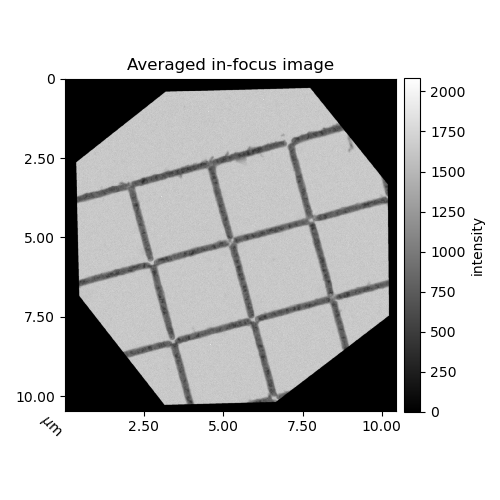

In [4]:
# view the in-focus image using the show_im function
show_im(
    tfs.infocus,
    title="Averaged in-focus image",
    scale=tfs.scale,
    cbar_title="intensity",
    cmap="gray",
)

interactive(children=(IntSlider(value=0, description='i', max=13), Output()), _dom_classes=('widget-interact',…

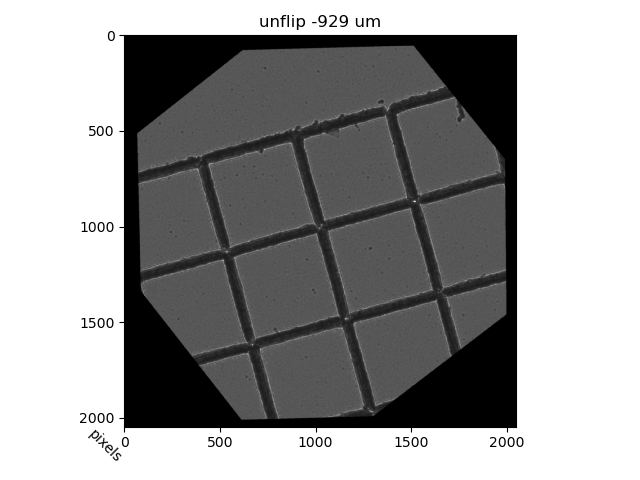

In [5]:
# Scroll through the full stack
full_titles = [f"{fl} {df/1e3:.0f} um" for fl, df in zip(['unflip']*tfs.len_tfs + ['flip']*tfs.len_tfs, tfs.full_defvals)]
show_stack(tfs.full_stack, titles=full_titles)

## Select a region of interest (optional)
There may be times when you would want to only reconstruct part of an image, e.g. because a window edge introduces a high-contrast edge that interferes with the reconstruction or surface contaminates. This can be done interactively in the notebook or manually by setting the ``tfs.transformations`` dictionary. 

<!-- Note that reconstructions of non-square regions can make the results non-quantitative, and that reconstructing regions with large aspect ratios $\scriptsize{\gtrsim}$ 3 will be qualitatively incorrect as well.  -->

Interactive ROI selection:
	Right click | move closest corner to mouse position
	'j'/'k'     | rotate the image, shift + 'j'/'k' to increase step size
	'n'/'m'     | grow/shrink the ROI, shift + 'n'/'m' to increase step size
	arrow keys  | move the ROI, + shift to increase step size
	'c'         | center the ROI on the middle of the image
	's'         | make the ROI square
	shift+'r'   | reset the ROI to the starting conditions
	shift+'f'   | restore the full image with zero rotation
	'esc'       | save transforms and exit
If display is not responding, try clicking on the image and ensuring you ran %matplotlib widget
Starting parameters: 


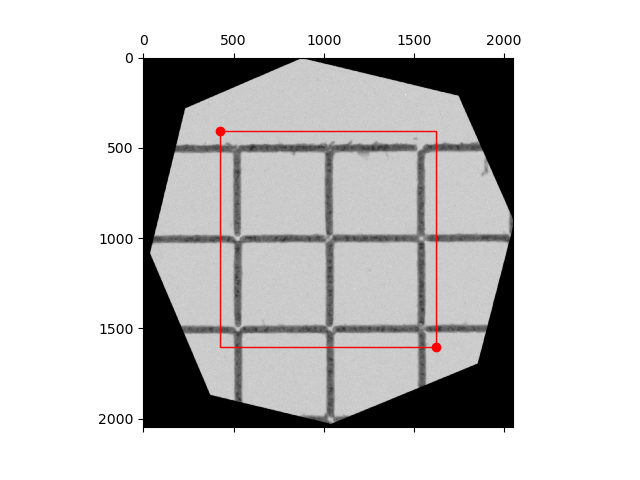

Current parameters:


Rotation:  -15 | Points: ( 404,  424), (1604, 1624) | Dimensions (h x w): 1200 x 1200
Setting transforms.
Final image dimensions (h x w): 1200 x 1200
Cropping can be returned to the full image by running self.reset_transforms()


In [95]:
# interactive selection requires matplotlib widget
tfs.select_ROI()
# will default to infocus image, but can input a specific image,
# e.g. dd.select_ROI(dd._orig_imstack[0]), must be of original input size

# In some cases, the interactive plot doesn't load at first. If this happens, try
# pressing j/k to rotate the image, as this will often force it to re-display.
# Or try re-running the cell.

Transformations can also set manually with a dictionary. 
Values can be overwritten/set individually:

In [15]:
print("Transforms dict:\n", tfs.transforms)

Transforms dict:
 {'rotation': -15, 'top': 435, 'bottom': 1615, 'left': 448, 'right': 1118}


In [ ]:
tfs.transforms = {"rotation": -15}

Once the transforms are set, then apply them with ``apply_transforms()``. This must be done in a new cell due to notebook/matplotlib compatability limitations. 


In [63]:
### for square/centered region, uncomment the following line:
tfs.transforms = {'rotation': -15, 'top': 404, 'bottom': 1604, 'left': 424, 'right': 1624}
tfs.apply_transforms()

Rotation:  -15 | Points: ( 404,  424), (1604, 1624) | Dimensions (h x w): 1200 x 1200


100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Once the transformations are applied, viewing the stacks will show only the transformed images. 

interactive(children=(IntSlider(value=0, description='i', max=13), Output()), _dom_classes=('widget-interact',…

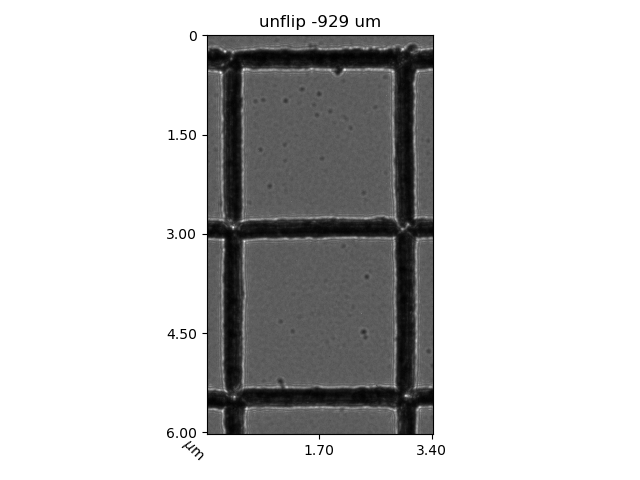

In [17]:
show_stack(tfs.full_stack, scale=tfs.scale, titles=full_titles)

The ROI can also be visualized overlaid on the original image, 

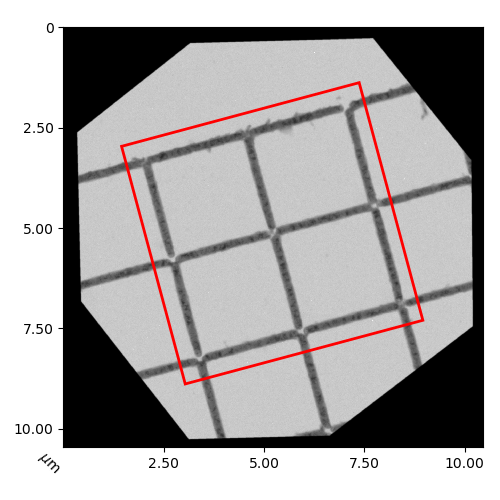

In [99]:
show_im(
    tfs.orig_infocus,
    roi=tfs.transforms,
    roi_color="r", # roi options passed as kwargs: roi_lw, roi_pad
    scale=tfs.scale,
    cbar=False,
)

## TIE phase reconstruction
The TIE reconstruction is performed with the TIE class, which is initialized using the TFS that we previously loaded. 



Here we perform the TIE reconstruction. The following parameters are set: 

* Set which focus values you want to use with index i 
* images will be saved as /dataloc/images/dataname_focusval_imagename.tif
* if you want to symmetrize the images set sym = True. 
    - This is primarily helpful if reconstructing images where one or more dimensions is an nearly prime number of pixels or if the aspect ratio of the reconstructed region is far from 1. 
* if you want to run with a Tikhonov frequency
    - qc = XX, allows you to input a frequency value in 1/nm
    - qc = None and it will run without a filter
* Save options:  
    - True    -- saves all images results directory
    - 'b'     -- saves 'color_b', 'bxt', 'byt'
    - 'color' -- saves just 'color_b'
    - False   -- Does not save images, but they can still be viewed in the notebook
    - If any images are saved, a dataname_params.txt file will be saved as well giving reconstruction parameters. 

In [ ]:
# TODO
# TIE notebook documentation, saving, show2D save, sym especially if reconstructing small regions
# SITIE for CGT
    # load image with DD (will show from numpy in Sim notebook)
    # filter (should be part of base_dataset)
    # SITIE, qc, sym

In [19]:
print(f'Defocus values (um): ± {np.round(tfs.defvals_index, -4)/1e3}')
print('Use defocus_index  =     0 ,  1 ,  2')

Defocus values (um): ± [200. 400. 930.]
Use defocus_index  =     0 ,  1 ,  2


Performing TIE reconstruction with defocus ± 929 um, index = 2
Reconstructing with two TFS flip/unflip to seperate phase_B and phase_E
dict_keys(['By', 'Bx', 'phase_B', 'phase_E', 'infocus', 'dIdZ_B', 'dIdZ_E'])


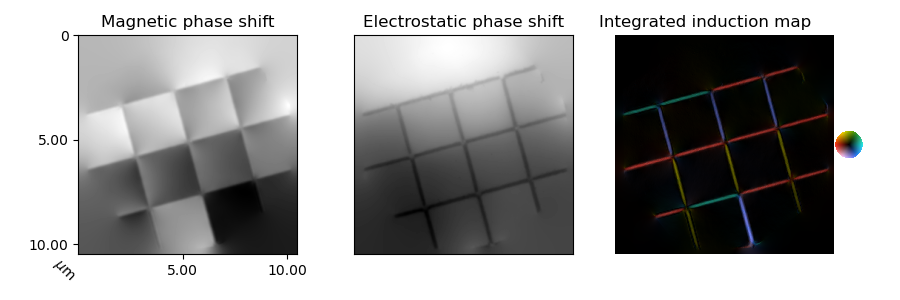

In [123]:
tie = TIE(tfs)

tie.reconstruct(
    index=2,
    # save=True, # bool, list of _results keys,
    # sym=True,
)
print(tie.results.keys())
tie.visualize()

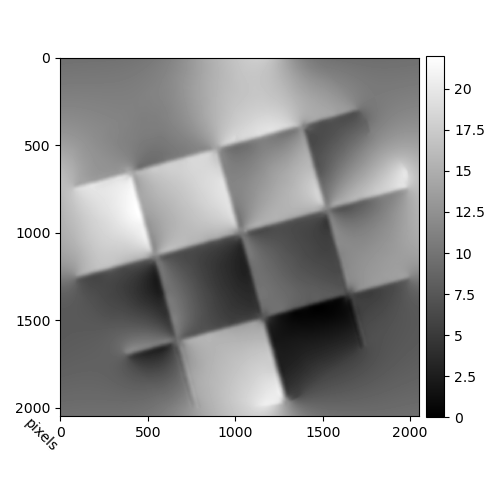

In [122]:
show_im(tie.phase_B)

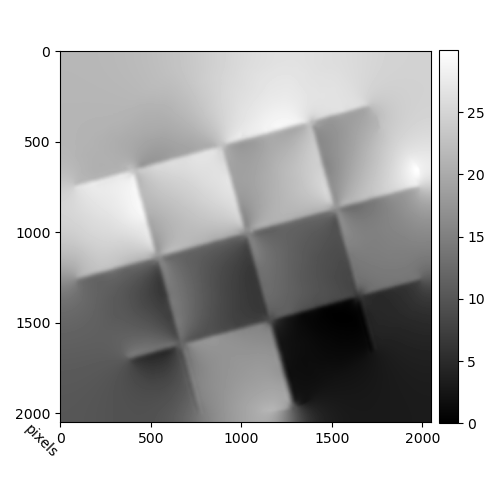

In [124]:
show_im(tie.phase_B)

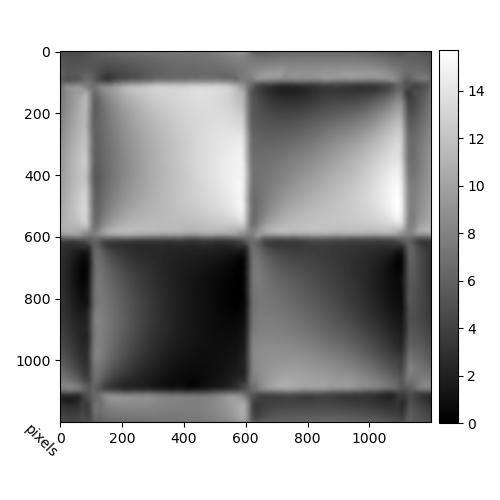

In [ ]:
show_im(tie.phase_B)

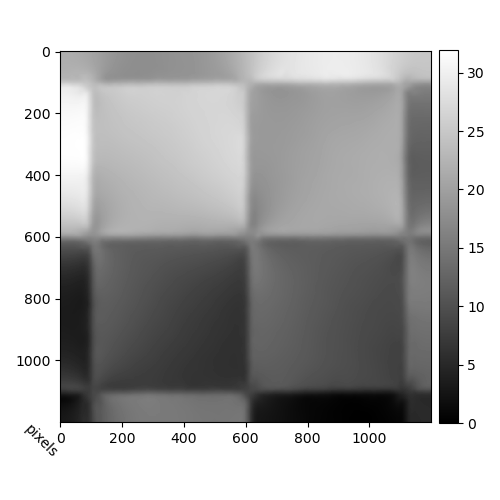

In [117]:
show_im(tie.phase_B)

In [ ]:
show_im(tie.phase_B)

In [ ]:
show_2D(tie.By, tie.Bx, cmap='4fold')

## Viewing the images
You can of course just look at the data where it's saved, but if you don't want to save it and move it to a local computer you can view the images here, as they're all in the results dictionary. 
* Results: 
    - 'byt' : y-component of integrated magnetic induction,
    - 'bxt' : x-component of integrated magnetic induction,
    - 'bbt' : magnitude of integrated magnetic induction, 
    - 'phase_b' : magnetic phase shift (radians),
    - 'phase_e' : electrostatic phase shift (if using flip stack) (radians),
    - 'dIdZ_b' : intensity derivative for calculating phase_m, (useful for troubleshooting)
    - 'dIdZ_e' : intensity derivative for calculating phase_e (if using flip stack), 
    - 'color_b' : RGB image of magnetic induction,
    - 'inf_im' : the in-focus image

In [75]:
75/15

5.0

rad pad:  75 14


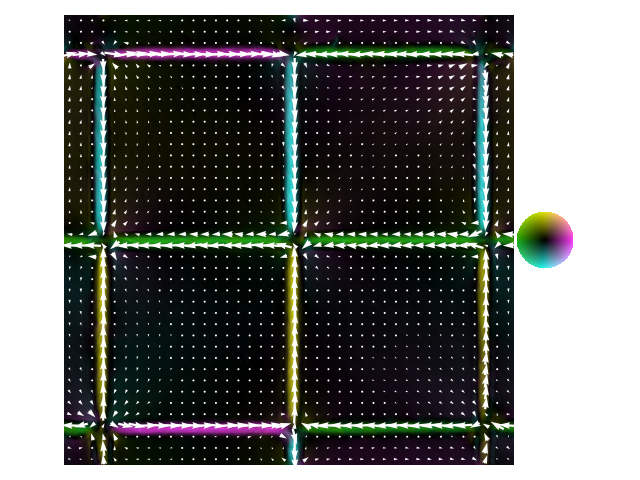

In [93]:
fname = f"{tie._save_name}_{tie._fmt_defocus(tie.recon_defval)}_B.png"
show_2D(tie.By,
        tie.Bx,
        num_arrows=40,
        arrow_size=2,
        arrow_width=6,
        cmap="4fold",
        # save=tie.save_dir / fname
        )

# see visualizations notebook for more

In [ ]:
show_im(results['phase_b'], title='magnetic phase shift', scale=ptie.scale,
        cbar_title="Radians")

In [ ]:
show_im(results['phase_e'], 'electrostatic phase shift',scale=ptie.scale,
        cbar_title="Radians")

Show the integrated induction vector map with a variety of color schemes: 
- Most of the colormaps are found in the [colorcet package](https://colorcet.holoviz.org/user_guide/Continuous.html#cyclic-colormaps)
    - "4fold"
    - "legacy4fold"
    - "hsv" (equivalent to "sixfold", default)
    - "legacyhsv" (equivalent to "purehsv", not a great choice for most situations)
    - "iso" (a 4-fold isoluminscent colormap)  

You can also pass a colormap object in to the cmap argument


In [ ]:
show_2D(results['bxt'], results['byt'], title="Magnetic induction with four-fold colormap",
        cmap='default')


Show a vector plot of the magnetic induction over the colormap image. The arrows size is fixed so you will have to zoom in to see them. There are a few parameters required to have the vectormap look good. 
- a (int): Number of arrows to show in the x and y directions
- l (float): Scale factor of arrows. Larger l -> shorter arrows. 
- w (float): Width scaling of arrows.
- title (str): (*optional*) Title for plot. Default None. 
- color (bool): (*optional*) Whether or not to show a colormap underneath the arrow plot.
- hsv (bool): (*optional*) Only relevant if color == True. Whether to use an hsv or 4-fold colorwheel in the color image. 
- origin (str): (*optional*) Control image orientation. 
- save (str): (*optional*) Path to save the figure. 

In [ ]:
show_2D(results['bxt'], results['byt'], a=40, l=1, w=4, title='Arrow overlay image', color=True, cmap='default',
        origin='upper')#, save = ptie.data_loc+'images/arrow_colormap.png')

### Single Image Reconstruction (SITIE)
Uniformly thin magnetic samples can be reconstructed from a single defocused image if their only source of contrast is magnetic Fresnel contrast. The previous example showed images of an island structure for which that is not the case, and we require two TFS to reconstruct the phase. 

Here we demonstrate the SITIE method for a simulated image of Neel type skyrmions. 

--- end notebook ---